# Generating the pyTDGL logo

The `SuperScreen` logo is a superconducting "S" screening a uniform applied magnetic field. This notebook generates the logo as follows:

1. Define a `matplotlib` `TextPath` object and use it to extract polygon vertices that draw an "S".
2. Create a `tdgl.Device` to represent the superconducting "S".
3. Solve for the response of the "S" to an applied magnetic field.
4. Visualize the resulting screening currents and fields.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
from matplotlib.path import Path
from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

import tdgl
from tdgl.geometry import close_curve
from tdgl.device.mesh import ensure_unique

SAVE = False

Define the `TextPath`:

In [2]:
loops_uppercase = "ABDOPQR"
loops_lowercase = "abdegopq"

In [3]:
def interp_path(path, points_per_segment=11):
    t = np.linspace(0, 1, points_per_segment)
    segments = [
        bezier(t) for bezier, code in path.iter_bezier() if code != Path.MOVETO
    ]
    points = np.concatenate(segments)
    return ensure_unique(points)


def make_polygon(letter, size, fontprops):
    path = TextPath((0, 0), letter, size=size, prop=fontprops)
    if letter in loops_lowercase + loops_uppercase:
        jumps = np.where(path.codes == TextPath.MOVETO)[0][1:]
        vertices = np.split(path.vertices, jumps)
        codes = np.split(path.codes, jumps)
        paths = [Path(v[:-1], c[:-1]) for v, c in zip(vertices, codes)]
    else:
        paths = [Path(path.vertices[:-1], path.codes[:-1])]
    polygons = [tdgl.Polygon(points=interp_path(p)) for p in paths]
    polygons = sorted(polygons, key=lambda p: p.area, reverse=True)
    for i, p in enumerate(polygons):
        if i == 0:
            p.name = letter
        else:
            p.name = f"{letter}_hole{i}"
    return polygons
        


def make_p_polygons(size, fontprops):
    path = TextPath((0, 0), "p", size=size, prop=fontprops)
    jump = np.where(path.codes == TextPath.CLOSEPOLY)[0][0]
    outer = Path(path.vertices[:jump], path.codes[:jump])
    inner = Path(path.vertices[jump + 1:], path.codes[jump + 1:])
    outer = tdgl.Polygon("p_outer", points=interp_path(outer))
    inner = tdgl.Polygon("p_inner", points=interp_path(inner))
    return outer, inner

def make_y_polygon(size, fontprops):
    path = TextPath((0, 0), "y", size=size, prop=fontprops)
    jump = np.where(path.codes == TextPath.CLOSEPOLY)[0][0]
    outer = Path(path.vertices[:jump], path.codes[:jump])
    outer = tdgl.Polygon("y_outer", points=interp_path(outer))
    # outer = outer.translate(dx=outer.extents[0])
    return outer

In [4]:
fontsize = 10
fontprops = FontProperties()

T, D, G, L = [make_polygon(letter, 10, fontprops) for letter in "TDGL"]

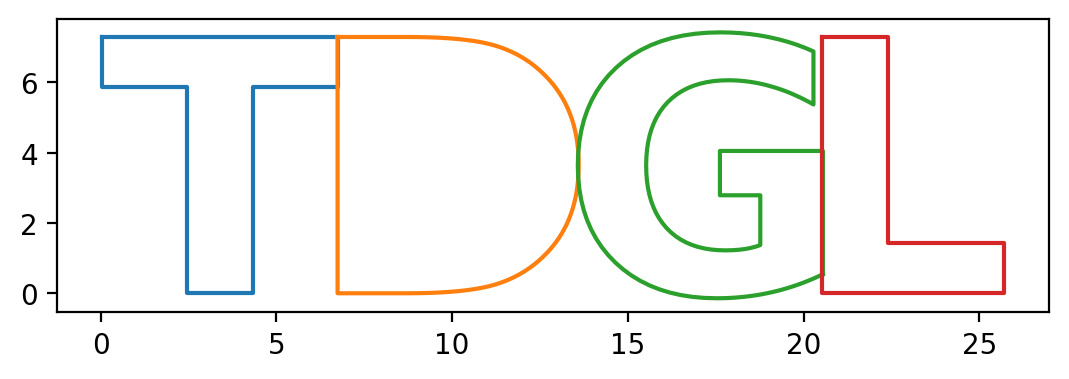

In [5]:
fig, ax = plt.subplots()

fontsize = 10
fontprops = FontProperties(weight="bold")

letters = T, D, G, L = [make_polygon(letter, 10, fontprops) for letter in "TDGL"]

for i, seq in enumerate(letters):
    polygon = seq[0]
    if i:
        prev_max = letters[i-1][0].points[:, 0].max()
        curr_min = polygon.points[:, 0].min()
        dx = prev_max-curr_min
        for p in seq:
            p.translate(dx=prev_max-curr_min-0.025, inplace=True)
#     dx = np.ptp(polygon.points[:, 0])
    polygon.plot(ax=ax)
    
film = tdgl.Polygon.from_union([seq[0] for seq in letters])
dx, dy = film.extents

In [7]:
xi = 0.3
layer = tdgl.Layer(london_lambda=10, coherence_length=xi, thickness=0.1)
device = tdgl.Device(
    "TDGL",
    layer=layer,
    film=film,
    holes=D[1:],
    #source_terminal=tdgl.Polygon(points=tdgl.geometry.box(3, 0.2, center=(3.5, -0.1))),
    #drain_terminal=tdgl.Polygon(points=tdgl.geometry.box(0.2, 2, center=(25.8, 0.75))),
).translate(dx=-dx/2, dy=-dy/2).scale(xfact=0.5, yfact=0.5)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='$x$ $[\\mathrm{µm}]$', ylabel='$y$ $[\\mathrm{µm}]$'>)

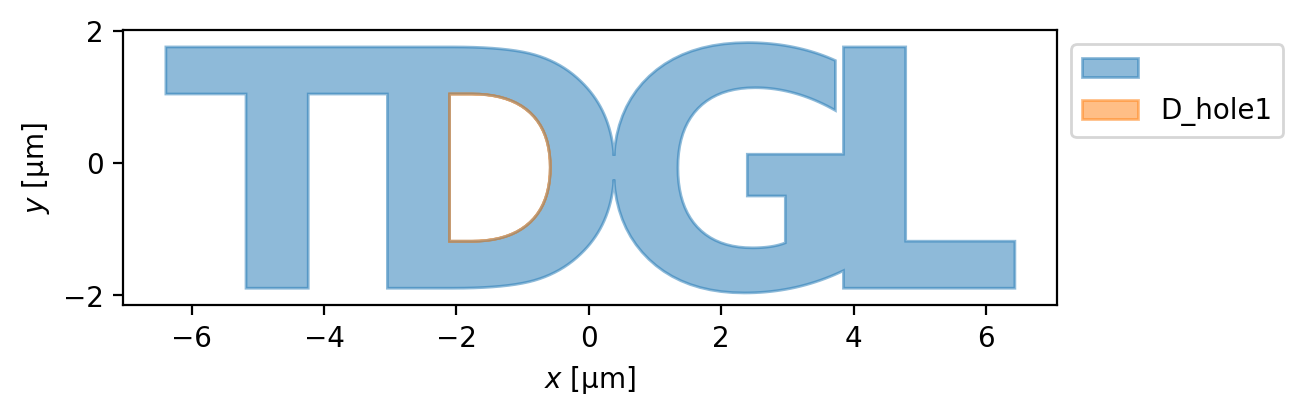

In [8]:
device.draw()

In [ ]:

device.coherence_length = xi

In [9]:
device.make_mesh(optimesh_steps=40, max_edge_length=xi * 0.5)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='$x$ $[\\mathrm{µm}]$', ylabel='$y$ $[\\mathrm{µm}]$'>)

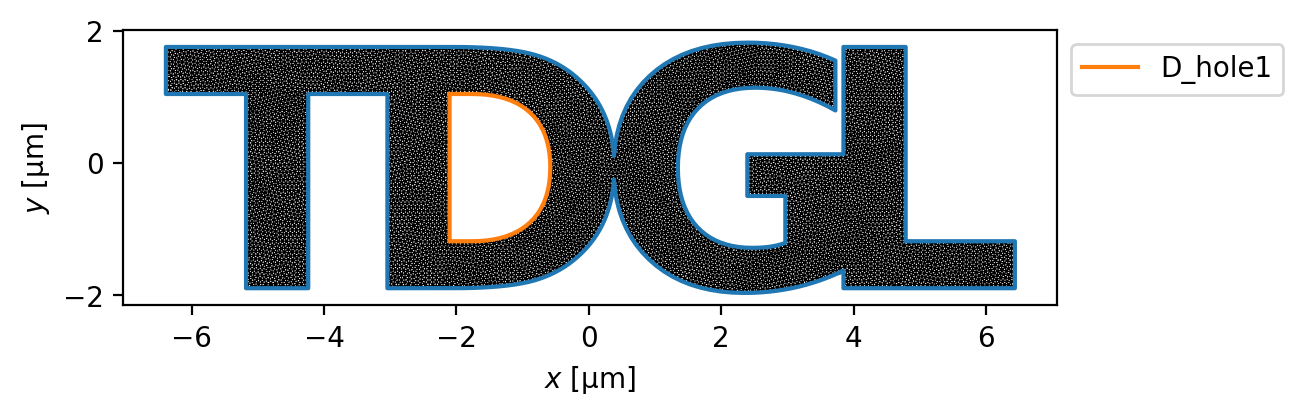

In [10]:
device.plot(mesh=True)

In [11]:
device.points.shape

(7910, 2)

In [15]:
dt = 1e-3
total_time = 1000

p_solution = tdgl.solve(
    device,
    "output-tdgl.h5",
    tdgl.SolverOptions(
        dt_min=dt,
        dt_max=20 * dt,
        total_time=total_time,
        adaptive_window=1,
        save_every=50,
    ),
    applied_vector_potential=tdgl.sources.ConstantField(4),
    field_units="mT",
    gamma=10,
    source_drain_current=0,
    current_units="uA",
    include_screening=False,
)

Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████▉| 1000/1000 [04:35<00:00,  3.63tau/s ]


(<Figure size 800x300 with 4 Axes>,
 array([<AxesSubplot: xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>,
        <AxesSubplot: xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>],
       dtype=object))

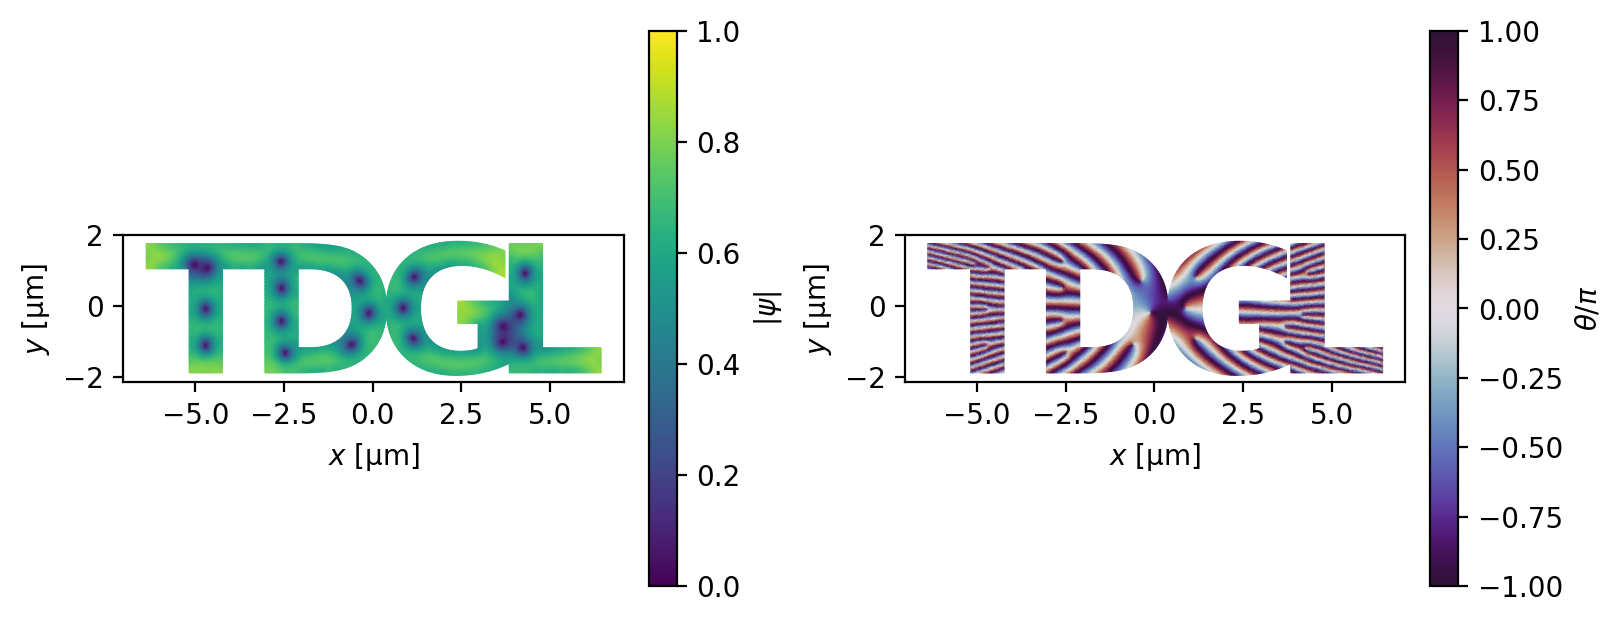

In [16]:
p_solution.plot_order_parameter()

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': '$|\\,\\vec{J}\\,|$'}, xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>)

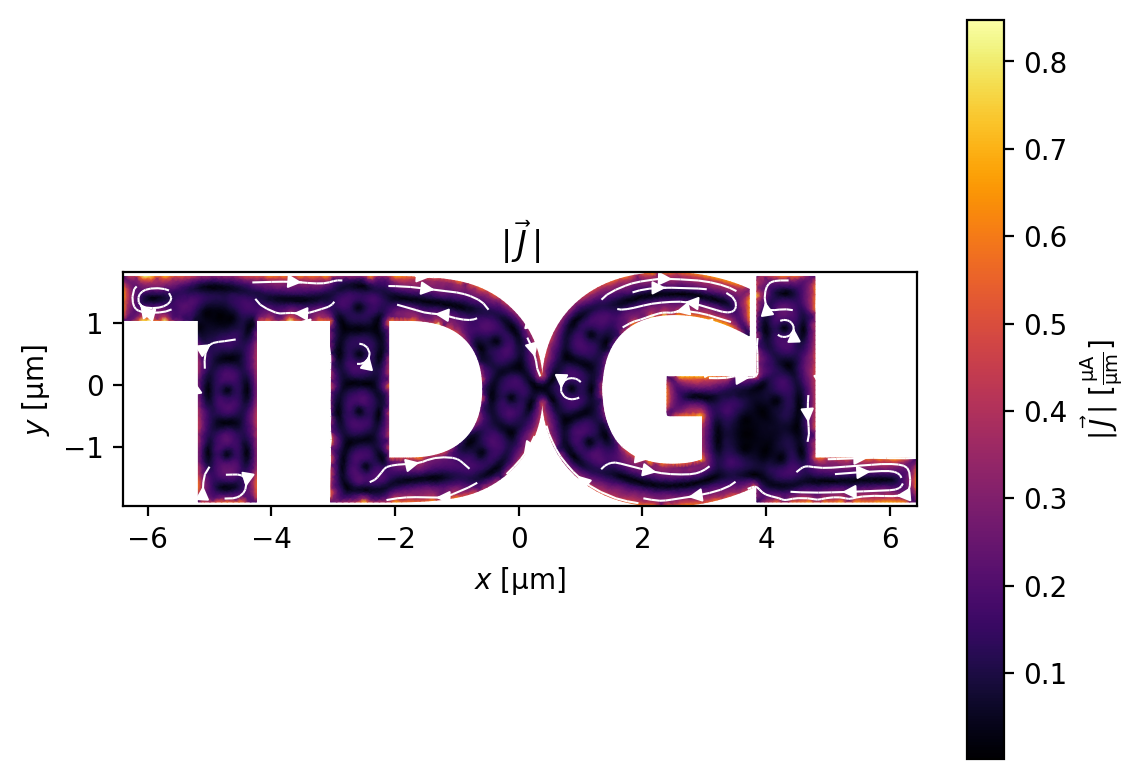

In [17]:
p_solution.plot_currents()

In [ ]:
fig, ax = plt.subplots()

ax.set_aspect("equal")
ax.axis("off")

for solution, x0 in zip((p_solution, y_solution), (0, 6.25)):
    device = solution.device
    xs, ys = device.points.T
    xs = xs + x0
    triangles = device.triangles
    psi = solution.tdgl_data.psi
    ax.tripcolor(xs, ys, triangles, np.abs(psi), cmap="viridis", shading="gouraud", antialiased=True)
    
if True or SAVE:
    fig.set_size_inches(3, 1)
    fig.set_facecolor("none")
    fig.savefig("../images/logo-transparent-small.png", dpi=300)

In [ ]:
tdgl.version_table()

In [ ]:
from tdgl.visualization import animate

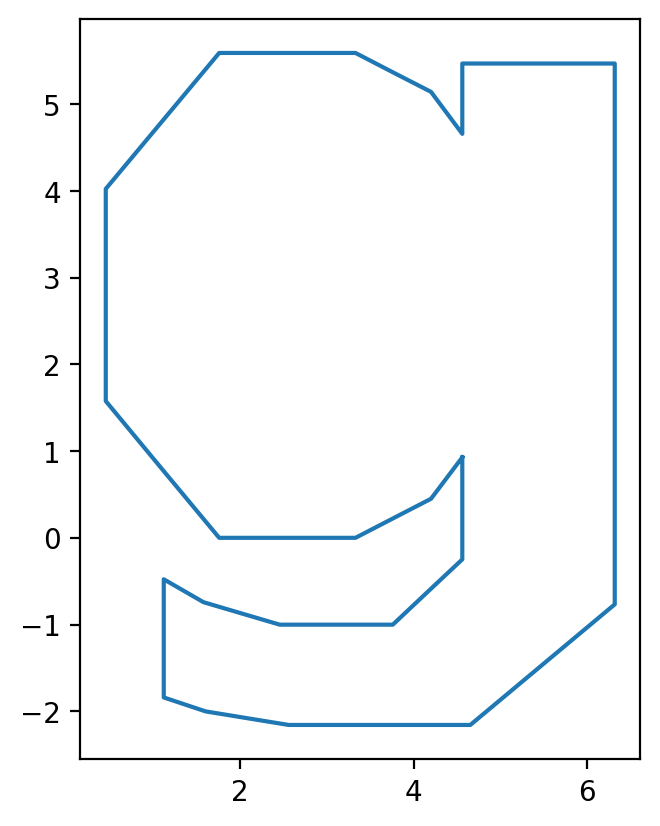

In [128]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(*paths[0].vertices[:-1].T)

In [3]:
fontsize = 10
fontprops = FontProperties(weight="bold")
xi = 0.4
layer = tdgl.Layer(london_lambda=10, coherence_length=xi, thickness=0.1)

In [4]:
p_outer, p_inner  = make_p_polygons(fontsize, fontprops)
y_outer  = make_y_polygon(fontsize, fontprops)

p_device = tdgl.Device("p", layer=layer, film=p_outer, holes=[p_inner])
y_device = tdgl.Device("y", layer=layer, film=y_outer)

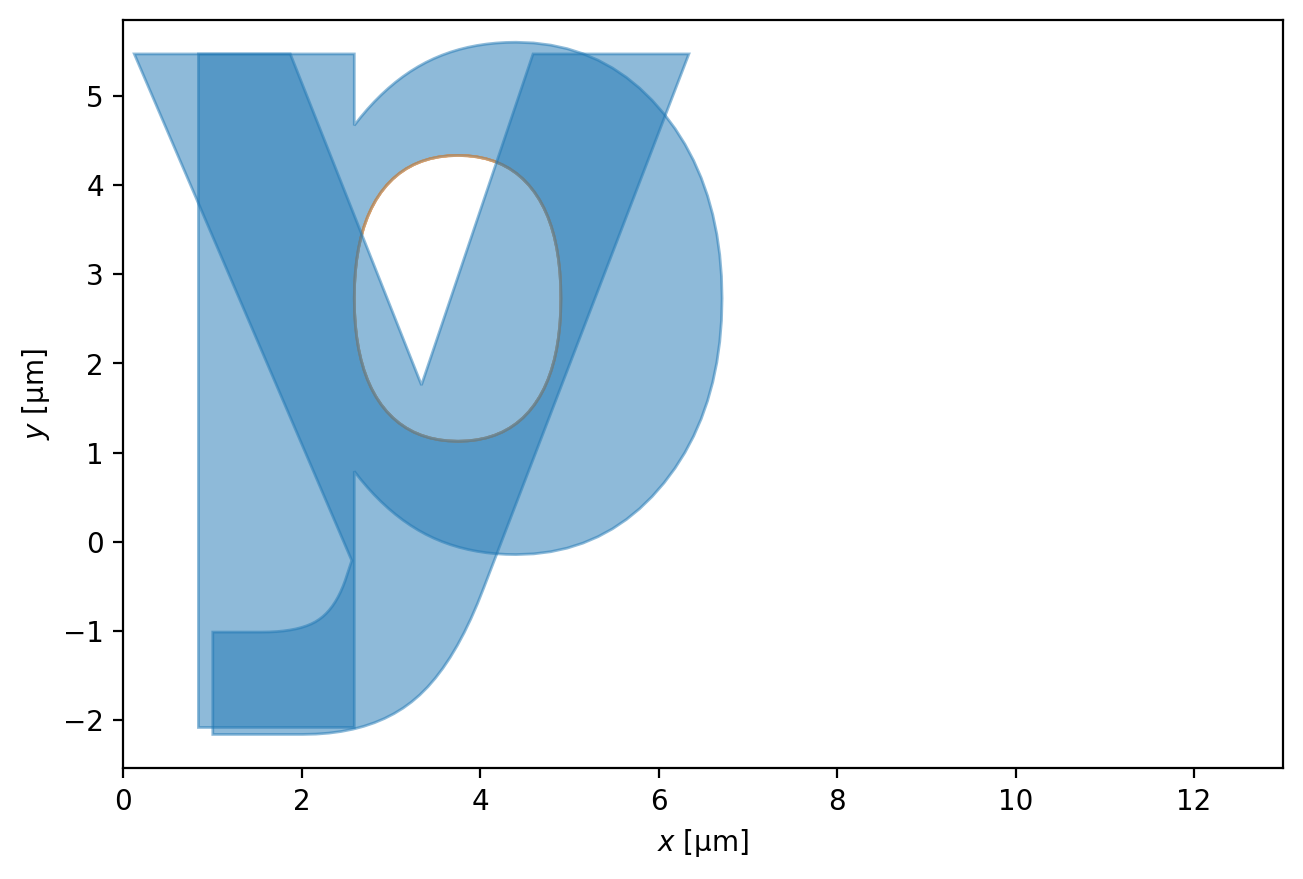

In [5]:
fig, ax = p_device.draw(legend=False)
_ = y_device.draw(ax=ax, legend=False)
_ = ax.set_xlim(0, 13)

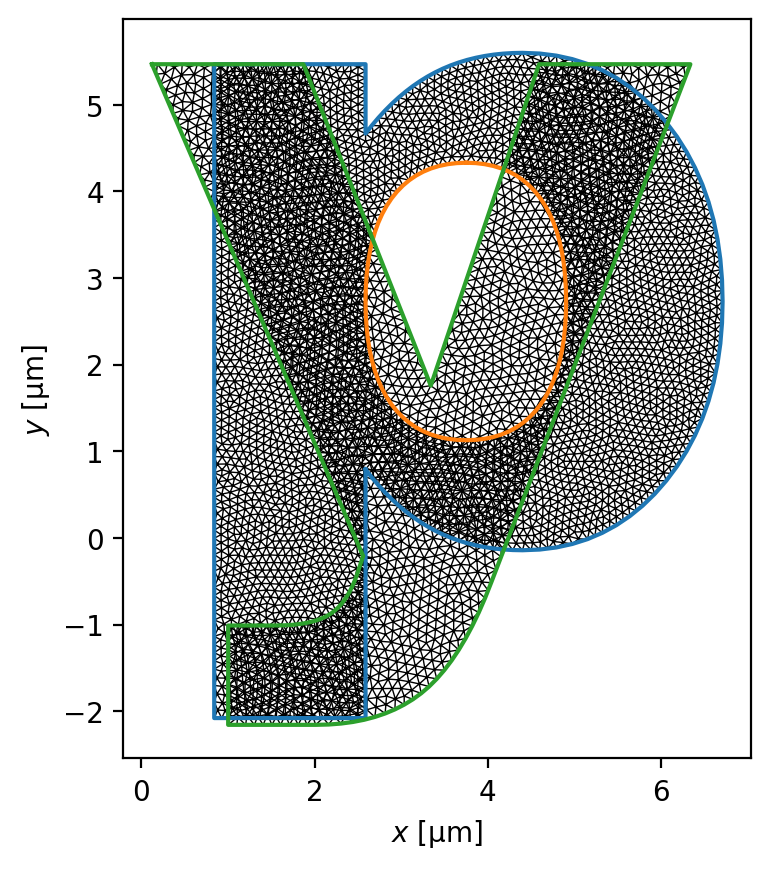

In [6]:
fig, ax = plt.subplots()
for device in (p_device, y_device):
    device.make_mesh(optimesh_steps=40, max_edge_length=xi / 2)
    device.plot(ax=ax, mesh=True, legend=False)

In [13]:
dt = 1e-3
total_time = 300

p_solution = tdgl.solve(
    p_device,
    "output-p.h5",
    tdgl.SolverOptions(
        dt_min=dt,
        dt_max=20 * dt,
        total_time=total_time,
        adaptive_window=1,
        save_every=50,
    ),
    applied_vector_potential=tdgl.sources.ConstantField(1.75),
    field_units="mT",
    gamma=10,
    source_drain_current=0,
    current_units="uA",
    include_screening=False,
)

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 300/300 [00:19<00:00, 15.38tau/s ]


In [14]:
dt = 1e-4

y_solution = tdgl.solve(
    y_device,
    "output-y.h5",
    tdgl.SolverOptions(
        dt_min=dt,
        dt_max=20 * dt,
        total_time=total_time,
        adaptive_window=1,
        save_every=50,
    ),
    applied_vector_potential=tdgl.sources.ConstantField(1.75),
    field_units="mT",
    gamma=10,
    source_drain_current=0,
    current_units="uA",
    include_screening=False,
)

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 300/300 [01:27<00:00,  3.43tau/s ]


(<Figure size 800x300 with 4 Axes>,
 array([<AxesSubplot: xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>,
        <AxesSubplot: xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>],
       dtype=object))

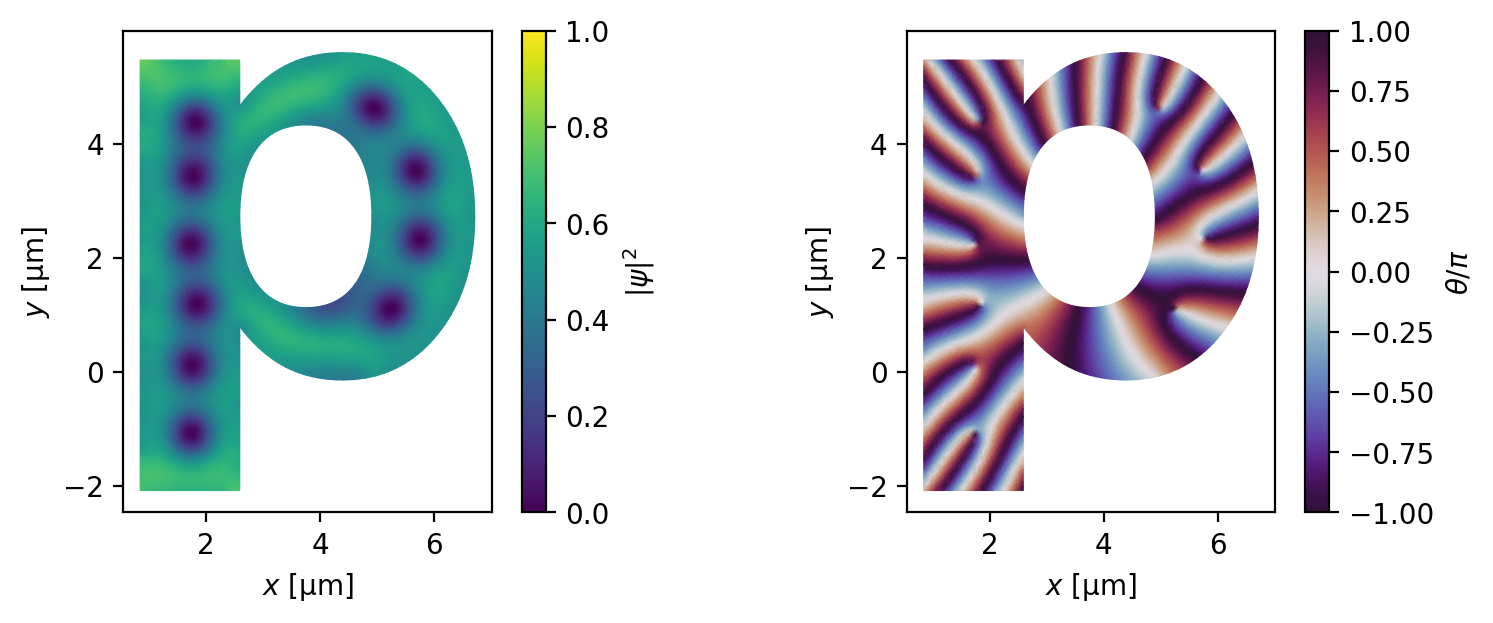

In [15]:
p_solution.plot_order_parameter()

(<Figure size 800x300 with 4 Axes>,
 array([<AxesSubplot: xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>,
        <AxesSubplot: xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>],
       dtype=object))

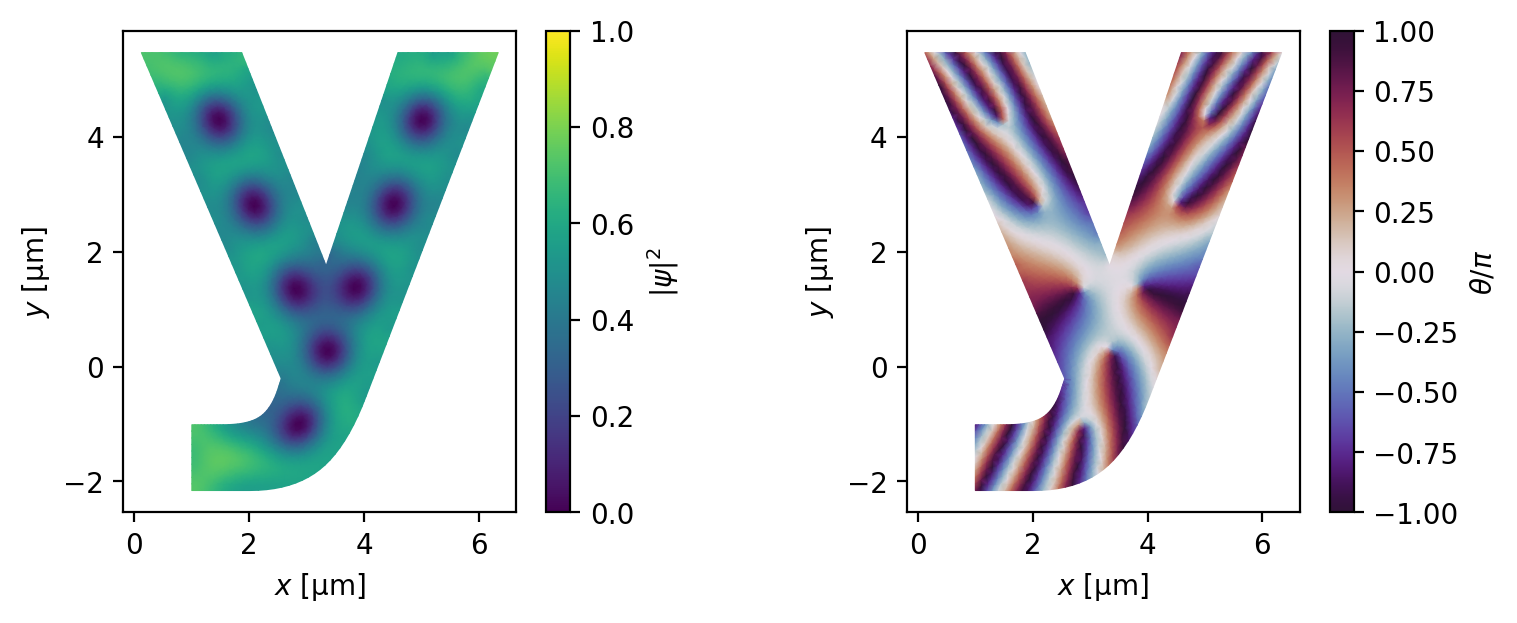

In [16]:
y_solution.plot_order_parameter()

In [ ]:
animate.MultiAnimate?

In [ ]:
plt.ioff()

animate.Animate(
    p_solution.path,
    p_solution.path.replace("h5", "mp4"),
    observables=("complex_field", "phase"),
    fps=60,
    dpi=200,
).build()

In [100]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'